In [1]:
import numpy as np
from math import pi
import matplotlib.pyplot as plt
from ase.build import bulk
from gpaw import GPAW, PW, FermiDirac
%matplotlib inline

DFT_ecut=400

# Part 1: Ground state calculation
atoms = bulk('Si', 'diamond', a=5.431)   # Generate diamond crystal structure for silicon

calc = GPAW(mode=PW(DFT_ecut),
            kpts={'density': 2.0, 'gamma': True},
            parallel={'band': 1, 'domain': 1},
            xc='PBE',
            occupations=FermiDirac(0.001),
            setups='sg15')  # use small FD smearing

atoms.set_calculator(calc)
atoms.get_potential_energy()  # get ground state density

# Restart Calculation with fixed density and dense kpoint sampling
calc.set(kpts={'density': 2.0, 'gamma': False},  # dense kpoint sampling
         fixdensity=True)
calc.diagonalize_full_hamiltonian(nbands=10)


  ___ ___ ___ _ _ _  
 |   |   |_  | | | | 
 | | | | | . | | | | 
 |__ |  _|___|_____|  1.4.0
 |___|_|             

User:   yzhumagulov@cpqm1
Date:   Wed Feb 13 16:40:01 2019
Arch:   x86_64
Pid:    10614
Python: 3.7.0
gpaw:   /home/yzhumagulov/anaconda3/lib/python3.7/site-packages/gpaw
_gpaw:  /home/yzhumagulov/anaconda3/lib/python3.7/site-packages/
        _gpaw.cpython-37m-x86_64-linux-gnu.so
ase:    /home/yzhumagulov/anaconda3/lib/python3.7/site-packages/ase (version 3.16.2)
numpy:  /home/yzhumagulov/anaconda3/lib/python3.7/site-packages/numpy (version 1.15.1)
scipy:  /home/yzhumagulov/anaconda3/lib/python3.7/site-packages/scipy (version 1.1.0)
units:  Angstrom and eV
cores:  1

Input parameters:
  kpts: {density: 2.0,
         gamma: True}
  mode: {ecut: 400.0,
         name: pw}
  occupations: {name: fermi-dirac,
                width: 0.001}
  setups: sg15
  xc: PBE

System changes: positions, numbers, cell, pbc, initial_charges, initial_magmoms 

Initialize ...

Norm-conservin

/home/yzhumagulov/anaconda3/lib/python3.7/site-packages/mkl_fft/_numpy_fft.py:244: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  output = mkl_fft.ifft(a, n, axis)


Creating initial wave functions:
  8 bands from LCAO basis set

                    
                    
                    
                    
           Si       
                    
       Si           
                    
                    
                    
                    

Positions:
   0 Si     0.000000    0.000000    0.000000    ( 0.0000,  0.0000,  0.0000)
   1 Si     1.357750    1.357750    1.357750    ( 0.0000,  0.0000,  0.0000)

Unit cell:
           periodic     x           y           z      points  spacing
  1. axis:    yes    0.000000    2.715500    2.715500    14     0.2240
  2. axis:    yes    2.715500    0.000000    2.715500    14     0.2240
  3. axis:    yes    2.715500    2.715500    0.000000    14     0.2240

  Lengths:   3.840297   3.840297   3.840297
  Angles:   60.000000  60.000000  60.000000

Effective grid spacing dv^(1/3) = 0.2444

                     log10-error:    total        iterations:
           time      wfs    density  energy       f

In [2]:
from ase.units import Bohr,Hartree
from tqdm import tqdm
from gpaw.wavefunctions.pw import PWDescriptor
from gpaw.kpt_descriptor import KPointDescriptor
from itertools import product

In [3]:
q=[0.0001,0,0]
kd=KPointDescriptor([[0,0,0]])
pd=PWDescriptor(ecut=50/Hartree,gd=calc.wfs.gd,kd=kd,dtype=complex)

In [4]:
volume = np.abs(np.linalg.det(calc.wfs.gd.cell_cv))
K=calc.get_ibz_k_points()
NK=K.shape[0]
EK=[calc.get_eigenvalues(k) for k in range(NK)]
EK=np.array(EK)/Hartree
wk=calc.get_k_point_weights()
nvalence=calc.occupations.nvalence
nbands=calc.get_number_of_bands()
vb=np.arange(0,nvalence/2,dtype=int)
cb=np.arange(nvalence/2,nbands,dtype=int)
norm=np.sqrt(Bohr**3*calc.wfs.gd.dv)
indexes=[(k,v,c) for k,v,c in product(range(NK),range(len(vb)),range(len(cb)))]
NH=len(indexes)
G=pd.get_reciprocal_vectors(add_q=True)

In [5]:
velocity=np.zeros((NH,3),dtype=np.complex)
rho=np.zeros((NH,G.shape[0]),dtype=np.complex)
for indx in tqdm(range(NH)):
    k,v,c=indexes[indx]
    wf1=calc.wfs.get_wave_function_array(n=vb[v],k=k,s=0,realspace=False)
    wf2=calc.wfs.get_wave_function_array(n=cb[c],k=k,s=0,realspace=False)
    G_=calc.wfs.pd.get_reciprocal_vectors(q=k,add_q=True)
    for i in range(3):
        velocity[indx,i]=calc.wfs.pd.integrate(wf1,G_[:,i]*wf2)/(EK[k,cb[c]]-EK[k,vb[v]])
    wf1=calc.get_pseudo_wave_function(vb[v],k)
    wf2=calc.get_pseudo_wave_function(cb[v],k)
    rho[indx]=pd.fft(wf2*wf1.conj())
velocity=q*velocity;velocity=velocity[:,0]

100%|██████████| 456/456 [00:00<00:00, 757.63it/s]


In [6]:
import numba

In [11]:
@numba.jit(nopython=True,parallel=True)
def calculate_chi(chi,rho,rho_,velocity,velocity_,omega,indexes,EK,wk):
    NH=rho.shape[0]
    for indx in numba.prange(NH):
        k,v,c=indexes[indx]
        denominator=omega+1j*eta-EK[k,cb[c]]+EK[k,vb[v]]
        for G1 in range(1,G.shape[0]):
            for G2 in range(1,G.shape[0]):
                chi[G1,G2]+=4*wk[k]*rho[indx,G1]*rho_[indx,G2]/denominator
        for G1 in range(G.shape[0]):
            chi[G1,0]+=4*wk[k]*rho[indx,G1]*velocity_[indx]/denominator
            chi[0,G1]+=4*wk[k]*velocity[indx]*rho_[indx,G1]/denominator
        chi[0,0]+=4*wk[k]*np.abs(velocity[indx])**2/denominator
    return chi

In [12]:
omega=np.linspace(0,20,20000)/Hartree;eta=0.05/Hartree
chi=np.zeros((G.shape[0],G.shape[0],omega.size),dtype=np.complex)
chi=calculate_chi(chi,rho,rho.conj(),velocity,velocity.conj(),omega,indexes,EK,wk)

In [13]:
V=np.diag(4*np.pi/(np.linalg.norm(G+q,axis=1)**2))
epsilon=np.zeros_like(chi)
for i in tqdm(range(omega.size)):
    epsilon[:,:,i]=np.eye(G.shape[0])-np.dot(V,chi[:,:,i])/volume

100%|██████████| 20000/20000 [00:01<00:00, 10453.09it/s]


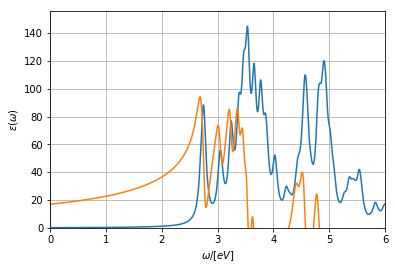

In [14]:
plt.plot(omega*Hartree,epsilon[0,0].imag)
plt.plot(omega*Hartree,epsilon[0,0].real)
plt.xlabel('$\\omega / [eV]$')
plt.ylabel('$\\epsilon(\\omega)$')
plt.xlim([0,6])
plt.ylim([0,None])
plt.grid()

In [15]:
epsilon[0,0,0].real

17.065474345621237

In [16]:
np.trapz(epsilon[0,0].imag*omega,omega)/(nvalence/volume)/(2*np.pi**2)

2.235900590175886